<a href="https://colab.research.google.com/github/NickMuhigi/ML-Capstone/blob/main/LSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Environment Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import Required Libraries

In [ ]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

Data Engineering – Train/Test Split (80/20)

In [ ]:
base_path = '/content/drive/MyDrive/Lumpy Skin Images Dataset'
new_base = '/content/drive/MyDrive/cattle_lsd_dataset'

classes = {'Lumpy Skin': 'LSD', 'Normal Skin': 'Healthy'}

for old_name, new_name in classes.items():
    source = os.path.join(base_path, old_name)
    train_dir = os.path.join(new_base, 'train', new_name)
    test_dir = os.path.join(new_base, 'test', new_name)

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    images = os.listdir(source)
    random.shuffle(images)
    split = int(0.8 * len(images))

    for img in images[:split]:
        shutil.copy(os.path.join(source, img), train_dir)

    for img in images[split:]:
        shutil.copy(os.path.join(source, img), test_dir)

print("Dataset split completed.")

Dataset split completed.


Data Visualization – Class Distribution

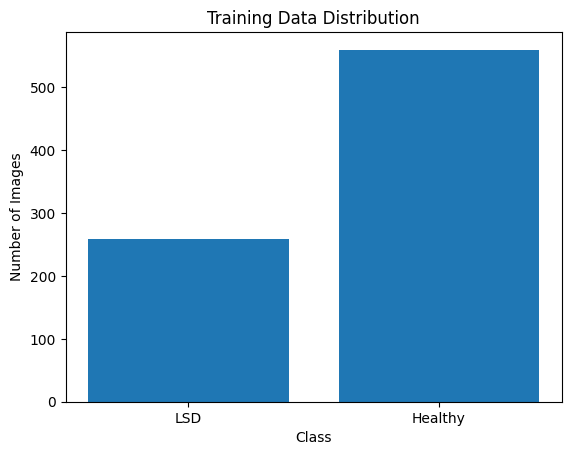

In [ ]:
train_path = '/content/drive/MyDrive/cattle_lsd_dataset/train'

classes = os.listdir(train_path)
counts = [len(os.listdir(os.path.join(train_path, c))) for c in classes]

plt.figure()
plt.bar(classes, counts)
plt.title("Training Data Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

Data Engineering – Augmentation & Normalization

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_data = datagen.flow_from_directory(
    train_path,
    target_size=(224,224),
    batch_size=8,
    class_mode='binary',
    subset='training'
)

val_data = datagen.flow_from_directory(
    train_path,
    target_size=(224,224),
    batch_size=8,
    class_mode='binary',
    subset='validation'
)

Found 656 images belonging to 2 classes.
Found 163 images belonging to 2 classes.


Handle Class Imbalance

In [ ]:
total = 324 + 700

class_weight = {
    0: total / (2 * 700),
    1: total / (2 * 324)
}

Model Architecture – Transfer Learning (MobileNetV2)

In [ ]:
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## **Model Architecture Explanation**

The model uses MobileNetV2, a pretrained Convolutional Neural Network (CNN), as a feature extractor.

*   Convolutional layers extract spatial features.
*   GlobalAveragePooling reduces dimensionality.
*   Dense layer (ReLU) learns classification features.
*   Dropout prevents overfitting.
*   Final Dense layer (Sigmoid) performs binary classification.

**Optimizer:** Adam,
**Loss Function:** Binary Crossentropy

Train Model

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5,
    class_weight=class_weight
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 69s 737ms/step - accuracy: 0.5260 - loss: 0.8783 - val_accuracy: 0.8098 - val_loss: 0.4610
Epoch 2/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 73s 632ms/step - accuracy: 0.7353 - loss: 0.5250 - val_accuracy: 0.9018 - val_loss: 0.3401
Epoch 3/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 53s 646ms/step - accuracy: 0.7477 - loss: 0.5143 - val_accuracy: 0.9018 - val_loss: 0.3441
Epoch 4/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 52s 631ms/step - accuracy: 0.8009 - loss: 0.4231 - val_accuracy: 0.9141 - val_loss: 0.3048
Epoch 5/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 53s 652ms/step - accuracy: 0.8251 - loss: 0.3926 - val_accuracy: 0.9080 - val_loss: 0.2747


Training Visualization

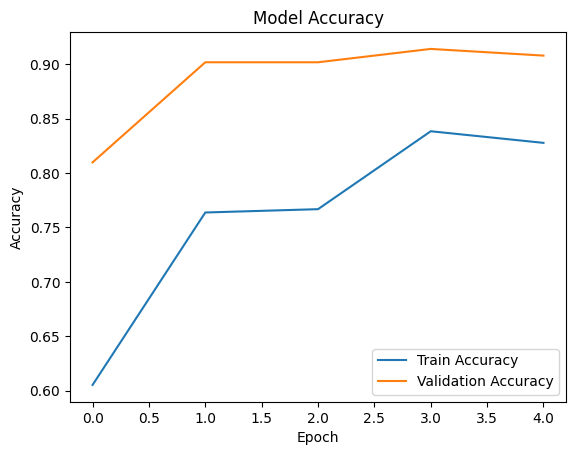

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Evaluate Performance

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)

test_data = test_gen.flow_from_directory(
    '/content/drive/MyDrive/cattle_lsd_dataset/test',
    target_size=(224,224),
    batch_size=8,
    class_mode='binary',
    shuffle=False
)

loss, acc = model.evaluate(test_data)
print("Test Accuracy:", acc)

Found 205 images belonging to 2 classes.
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 430ms/step - accuracy: 0.9195 - loss: 0.2524
Test Accuracy: 0.8780487775802612


Precision, Recall, F1 Score

In [ ]:
predictions = model.predict(test_data)
y_pred = (predictions > 0.5).astype(int)

print(classification_report(
    test_data.classes,
    y_pred,
    target_names=['Healthy', 'LSD']
))

26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 443ms/step
              precision    recall  f1-score   support

     Healthy       0.90      0.92      0.91       140
         LSD       0.82      0.78      0.80        65

    accuracy                           0.88       205
   macro avg       0.86      0.85      0.86       205
weighted avg       0.88      0.88      0.88       205



Confusion Matrix

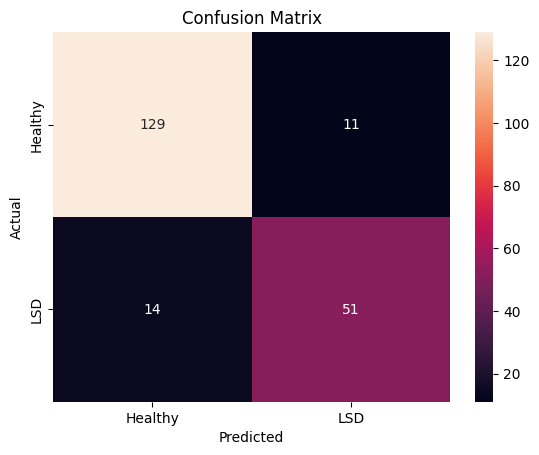

In [ ]:
cm = confusion_matrix(test_data.classes, y_pred)

plt.figure()
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=['Healthy','LSD'],
            yticklabels=['Healthy','LSD'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Save Model

In [ ]:
model.save("lsd_model.h5")

from google.colab import files
files.download("lsd_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>